In [31]:
import os
from io import BytesIO
import imageio.v2 as imageio
import torch
import cv2 as cv
import numpy as np
from pyhdf.SD import SD, SDC
from os.path import join as path_join
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
FILE_NAMES = ["br002.hdf"]

In [3]:
def read_hdf(hdf_path, dataset_names):
    print(f"Reading {hdf_path}")
    f = SD(hdf_path, SDC.READ)
    datasets = []
    for dataset_name in dataset_names:
        datasets.append(f.select(dataset_name).get())
    return datasets

In [8]:
def resize_3d(array, new_height, new_width):
    resized_array = np.zeros((array.shape[0], new_height, new_width))
    print(array.shape, new_height, new_width)

    for i in range(array.shape[0]):
        resized_array[i] = cv.resize(
            array[i], (new_width, new_height), interpolation=cv.INTER_LINEAR
        )

    return resized_array


def get_sim(sim_path, new_height, new_width):
    (b_path,) = [path_join(sim_path, file_name) for file_name in FILE_NAMES]
    b, k = read_hdf(b_path, ["Data-Set-2", "fakeDim2"])

    k = np.expand_dims(np.expand_dims(k, axis=0), axis=0)
    b *= k**2

    b = b.transpose(2, 1, 0)
    
    b = resize_3d(b, new_height, new_width)

    return b


def get_sims(sim_paths, new_height, new_width):
    sims = []
    for sim_path in sim_paths:
        sims.append(get_sim(sim_path, new_height, new_width))
    sims = np.stack(sims, axis=0)
    return sims


def min_max_normalize(array, min_=None, max_=None):
    if min_ is None or max_ is None:
        min_ = np.min(array)
        max_ = np.max(array)
    array = (array - min_) / (max_ - min_)
    return array, min_, max_


class SphericalNODataset(Dataset):
    def __init__(
        self,
        sim_paths,
        height=110,
        width=128,
        b_min=None,
        b_max=None,
    ):
        super().__init__()
        sims = get_sims(sim_paths, height, width)
        sims, self.b_min, self.b_max = min_max_normalize(sims, b_min, b_max)
        self.sims = sims

    def __getitem__(self, index):
        cube = self.sims[index]
        return {
            "x": torch.tensor(cube[0, :, :], dtype=torch.float32).unsqueeze(0),
            "y": torch.tensor(cube[1:, :, :], dtype=torch.float32),
        }

    def __len__(self):
        return len(self.sims)

    def get_min_max(self):
        return {"b_min": float(self.b_min), "b_max": float(self.b_max)}

In [9]:
instruments = [
        "kpo_mas_mas_std_0101",
        "mdi_mas_mas_std_0101",
        "hmi_mast_mas_std_0101",
        "hmi_mast_mas_std_0201",
        "hmi_masp_mas_std_0201",
        "mdi_mas_mas_std_0201",
]

In [10]:
subdir_paths = sorted(os.listdir('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train'))
cr_paths = [path_join('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train', p) for p in subdir_paths if p.startswith("cr")]
sim_paths_train = []
for cr_path in cr_paths:
    for instrument in instruments:
        instrument_path = path_join(cr_path, instrument)
        if os.path.exists(instrument_path):
            sim_paths_train.append(instrument_path)
subdir_paths = sorted(os.listdir('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/test'))
cr_paths = [path_join('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/test', p) for p in subdir_paths if p.startswith("cr")]
sim_paths_val = []
for cr_path in cr_paths:
    for instrument in instruments:
        instrument_path = path_join(cr_path, instrument)
        if os.path.exists(instrument_path):
            sim_paths_val.append(instrument_path)

In [13]:
train_dataset = SphericalNODataset(sim_paths_train[:10], 32, 64)
val_dataset = SphericalNODataset(sim_paths_val[:1], 32, 64, b_min=train_dataset.b_min, b_max=train_dataset.b_max)

Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1732/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1733/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1734/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1735/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1736/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1737/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1738/kpo_mas_mas_std_0101/br002.hdf
(141, 110, 128) 32 64
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1739/kpo_mas_mas_std_0101/

torch.Size([10, 1, 32, 64]) torch.Size([10, 140, 32, 64])


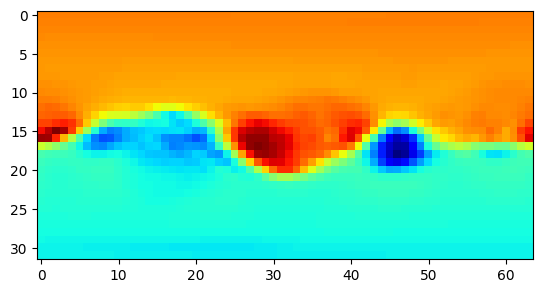

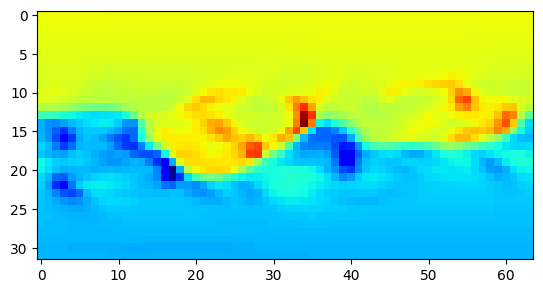

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Check a batch
sample_batch = next(iter(train_loader))
print(sample_batch['x'].shape, sample_batch['y'].shape)  # Should be (16, 128, 110)
plt.imshow(sample_batch['x'][0].numpy()[0], cmap='jet_r')
plt.show()
plt.imshow(sample_batch['y'][0].numpy()[100], cmap='jet_r')
plt.show()


In [16]:
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
model = SFNO(n_modes=(32, 32),
             in_channels=1,
             out_channels=140,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 284332 parameters.


In [25]:
optimizer = AdamW(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [26]:
l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [27]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projectio

In [28]:
trainer = Trainer(model=model, n_epochs=1000,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [29]:
trainer.train(train_loader=train_loader,
              test_loaders={(32, 64): val_loader},
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 10 samples
Testing on [1] samples         on resolutions [(32, 64)].
Raw outputs of shape torch.Size([10, 140, 32, 64])
[0] time=0.17, avg_loss=136.0838, train_err=1360.8384
Eval: (32, 64)_l2=134.5899
[3] time=0.11, avg_loss=131.8151, train_err=1318.1510
Eval: (32, 64)_l2=130.1234
[6] time=0.12, avg_loss=127.1329, train_err=1271.3286
Eval: (32, 64)_l2=125.2060
[9] time=0.11, avg_loss=122.0011, train_err=1220.0109
Eval: (32, 64)_l2=119.8556
[12] time=0.12, avg_loss=116.5665, train_err=1165.6646
Eval: (32, 64)_l2=114.3019
[15] time=0.13, avg_loss=111.2055, train_err=1112.0548
Eval: (32, 64)_l2=108.9955
[18] time=0.12, avg_loss=106.4466, train_err=1064.4663
Eval: (32, 64)_l2=104.4912
[21] time=0.12, avg_loss=102.7990, train_err=1027.9900
Eval: (32, 64)_l2=101.2481
[24] time=0.12, avg_loss=100.5359, train_err=1005.3586
Eval: (32, 64)_l2=99.4195
[27] time=0.11, avg_loss=99.5470, train_err=995.4697
Eval: (32, 64)_l2=98.7565
[30] time=0.11, avg_loss=99.3587, train_err=993.5867
Eva

{'train_err': 50.22029113769531,
 'avg_loss': 5.022029113769531,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.1991179159999774,
 '(32, 64)_l2': tensor(7.1218)}

In [35]:
test_samples = train_loader.dataset
data = test_samples[np.random.randint(0, len(test_samples))]
# Input x
x = data['x']
# Ground-truth
y = data['y'].numpy()
# Model prediction
x_in = x.unsqueeze(0).to(device)
out = model(x_in).squeeze().detach().cpu().numpy()
x = x[0, ...].detach().numpy()

frames = []
for i in range(140):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x, cmap='jet_r')
    ax.set_title(f'Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y[i], cmap='jet_r')
    ax.set_title(f'Ground-truth y[{i}]')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(out[i], cmap='jet_r')
    ax.set_title(f'Model prediction[{i}]')
    plt.xticks([], [])
    plt.yticks([], [])

    # fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
    plt.tight_layout()
    # fig.show()
    buf = BytesIO()
    plt.savefig(buf, format="png")
    frames.append(imageio.imread(buf))
    plt.close()

In [36]:
output_filename = f"b.gif"
fps = 10  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)